# Network Analysis of Street Networks

In this notebook, I analyzed the street networks of various cities by computing different network indices and visualizing the original graph and the Minimum Spanning Tree (MST). The analysis includes:
- Place/Network area in square kilometers.
- Network length in kilometers.
- Network density (km/km^2).
- Alpha, Beta, and Gamma indices for the graph.
- Length and density of the Minimum Spanning Tree.

I used the `osmnx` library to obtain and process the graphs and `matplotlib` for visualizations.

In [7]:
import osmnx as ox 
import networkx as nx 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def network_analysis(names):
    # Initialize an empty dictionary to store results
    results = {
        "name": [], 
        "area [km^2]": [], 
        "network length [km]": [], 
        "network density [km/km^2]": [],
        "network length MST [km]": [],
        "network density MST [km/km^2]": [],
        "alpha": [], 
        "beta": [], 
        "gamma": [] 
    }

    for name in names:
        results["name"].append(name)

        # Retrieve the street network graph for the place
        G = ox.graph.graph_from_place(name, network_type="drive")
        
        # Project the graph to a consistent CRS (coordinate reference system)
        G_proj = ox.projection.project_graph(G)
        
        # Simplify the graph by consolidating intersections
        G_cons = ox.simplification.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=20, dead_ends=False)
        
        # Convert the graph to an undirected graph for analysis
        G_und = ox.convert.to_undirected(G_cons)
        
        # Convert graph to GeoDataFrames for further analysis
        nodes_und, edges_und = ox.convert.graph_to_gdfs(G_und)

        # Calculate the number of nodes (v) and edges (e)
        v = len(G_und.nodes)
        e = len(G_und.edges)

        # Skip the graph if it has fewer than 2 nodes
        if v <= 2:
            print("Graph must have more than 2 nodes to compute indices.")
            continue

        # Compute the alpha, beta, and gamma indices based on the graph's properties
        e_max = 3 * (v - 2)  # assuming planar graph
        gamma = e / e_max if e_max != 0 else 0
        alpha = (e - v + 1) / (2 * v - 5) if (2 * v - 5) != 0 else 0
        beta = e / v if v != 0 else 0

        # Store the calculated indices
        results["alpha"].append(round(alpha, 2))
        results["beta"].append(round(beta, 2))
        results["gamma"].append(round(gamma, 2))

        # Calculate the area of the graph's bounding box in km^2
        area = nodes_und.geometry.union_all().convex_hull.area
        area_km2 = area / 1_000_000

        # Calculate total network length in kilometers
        total_length_m = edges_und['length'].sum()
        total_length_km = total_length_m / 1000

        # Calculate network density (length per area)
        network_density = total_length_km / area_km2

        # Store these values
        results["area [km^2]"].append(round(area_km2, 2))
        results["network length [km]"].append(round(total_length_km, 2))
        results["network density [km/km^2]"].append(round(network_density, 2))

        # Calculate the Minimum Spanning Tree (MST)
        edges = list(G_und.edges(data=True))
        edges.sort(key=lambda edge: edge[2]['length'])  # Sort edges by length
        
        # Initialize the MST as an empty list
        mst_edges = []

        # Track connected components (disjoint sets)
        components = {node: {node} for node in G_und.nodes()}

        # Go through the sorted edges to construct the MST
        for u, v, attrs in edges:
            if components[u] != components[v]:
                mst_edges.append((u, v, attrs['length']))
                # Merge components
                new_component = components[u].union(components[v])
                for node in new_component:
                    components[node] = new_component

        # Skip if no edges were selected for MST
        if len(mst_edges) == 0:
            print(f"No edges in MST for {name}. Skipping MST plot.")
            continue

        # Create an empty graph for the MST
        G_mst = nx.MultiGraph()
        G_mst.graph['crs'] = G_und.graph['crs']

        # Add all nodes (with their attributes)
        for node, data in G_und.nodes(data=True):
            G_mst.add_node(node, **data)

        # Add MST edges (with geometry and other edge attributes)
        for u, v, _ in mst_edges:
            for key in G_und[u][v]:
                edge_data = G_und[u][v][key]
                G_mst.add_edge(u, v, **edge_data)

        nodes_mst, edges_mst = ox.convert.graph_to_gdfs(G_mst)

        # Calculate network length and density for the MST
        total_length_m_mst = edges_mst['length'].sum()
        total_length_km_mst = total_length_m_mst / 1000
        network_density_mst = total_length_km_mst / area_km2

        results["network length MST [km]"].append(round(total_length_km_mst, 2))
        results["network density MST [km/km^2]"].append(round(network_density_mst, 2))

        # Plot the original graph and the MST side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the original graph
        ox.plot.plot_graph(G_und, node_size=0, ax=axes[0], show=False)
        axes[0].set_title(f"Original Graph - {name}")

        # Plot the MST
        ox.plot.plot_graph(G_mst, node_size=0, ax=axes[1], show=False)
        axes[1].set_title(f"Minimum Spanning Tree - {name}")

        # Display the plots
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results).head()

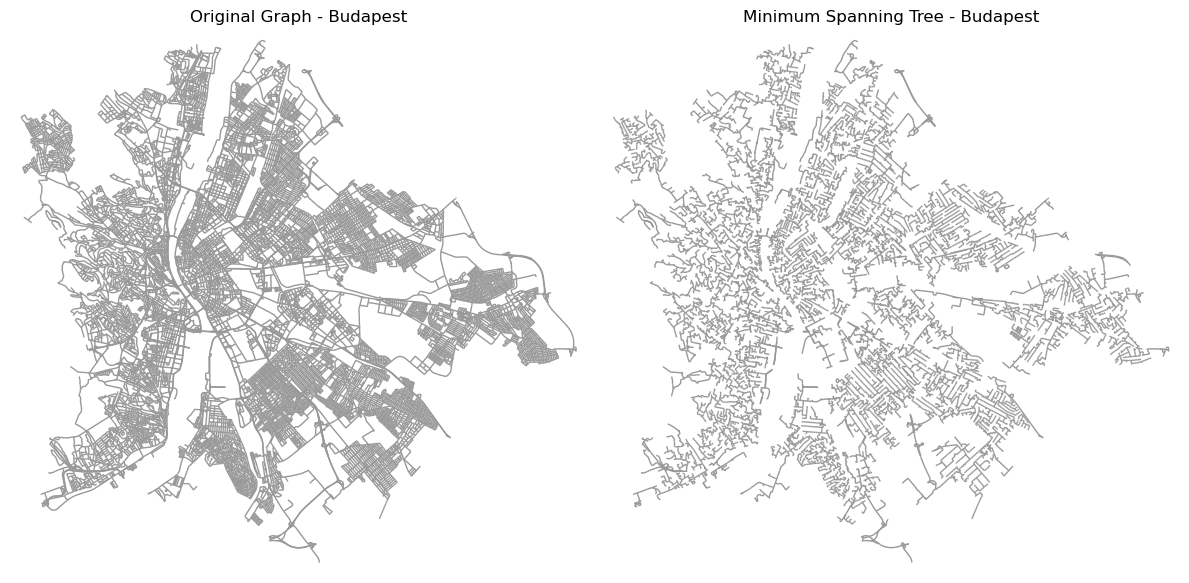

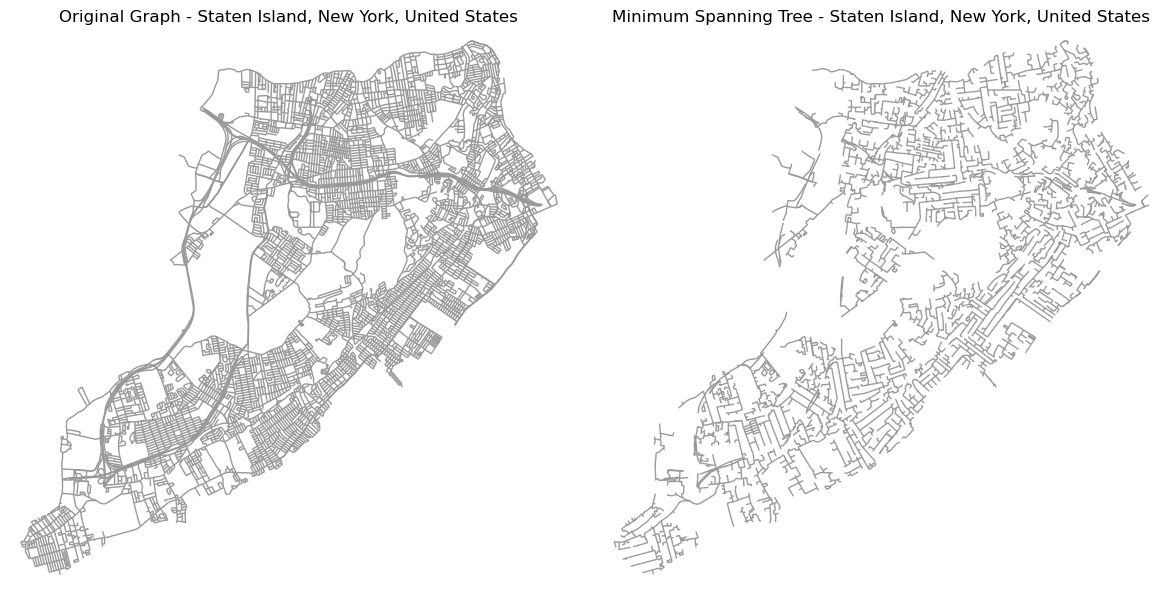

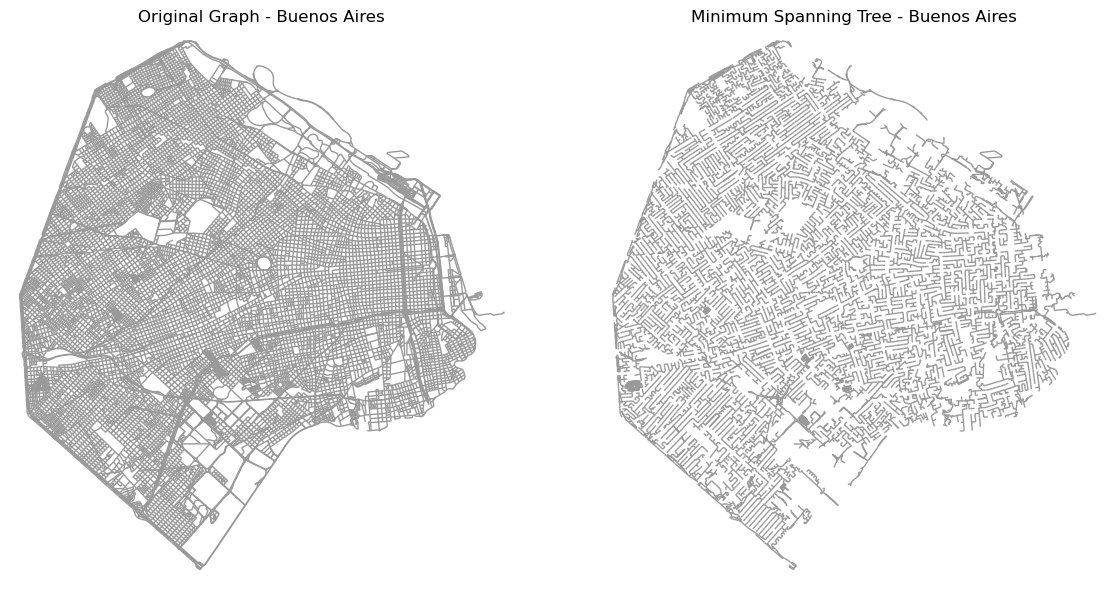

,name,area [km^2],network length [km],network density [km/km^2],network length MST [km],network density MST [km/km^2],alpha,beta,gamma
0,Budapest,597.16,4263.68,7.14,1822.55,3.05,0.35,1.70,0.57
1,"Staten Island, New York, United States",152.39,1476.07,9.69,657.39,4.31,0.31,1.63,0.54
2,Buenos Aires,211.56,3486.60,16.48,1468.06,6.94,0.48,1.97,0.66


In [9]:
# List of city names for analysis (chosen randomly)
names = ["Budapest", "Staten Island, New York, United States", "Buenos Aires"]
network_analysis(names)

# Discussion

From the visualizations and metrics, we can observe that the Minimum Spanning Tree (MST) often provides a more condensed representation of the network, removing redundant connections, which is reflected in the lower network density and reduced length.

The Alpha, Beta, and Gamma indices help characterize the overall connectivity and structure of the networks.